In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import yfinance as yf


In [13]:
tickers=pd.read_html('https://en.wikipedia.org/wiki/List_of_S&P_500_companies')[0]['Symbol']
print(tickers)

0       MMM
1       AOS
2       ABT
3      ABBV
4       ACN
       ... 
498     YUM
499    ZBRA
500     ZBH
501    ZION
502     ZTS
Name: Symbol, Length: 503, dtype: object


[*********************100%***********************]  1 of 1 completed
['1d_Prev_close', '1d_Prev_volume', '1d_Weekday', '1d_13EMA', '1d_26EMA', '1d_50EMA', '1d_200EMA', '1d_MACD', '1d_MACD_signal', '1d_RSI', '1d_RSI_volume']


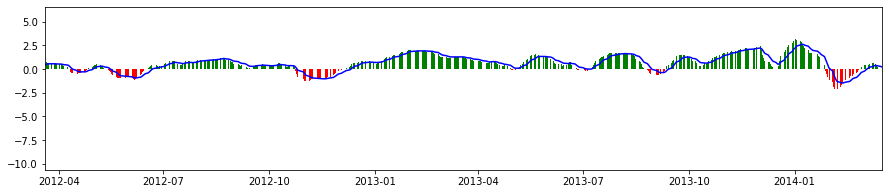

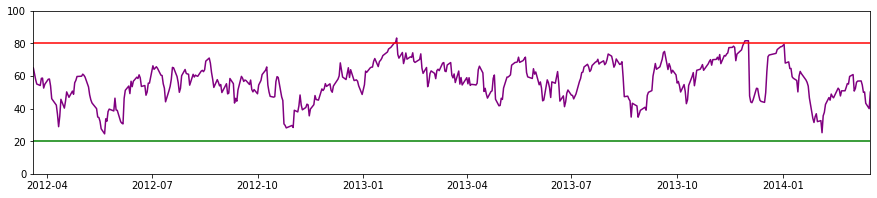

,Open,Close,Volume,Prev_close,Prev_volume,Weekday,13EMA,26EMA,50EMA,200EMA,MACD,MACD_signal,RSI,RSI_volume
Date,,,,,,,,,,,,,,
2008-04-02,81.239998,80.910004,2871700,81.320000,4813600.0,2,79.460001,79.310742,79.235099,79.171594,0.173105,0.034621,100.000000,100.000000
2008-04-03,80.589996,80.169998,3280600,80.910004,2871700.0,3,79.667144,79.429206,79.300782,79.188891,0.274050,0.082507,98.567448,89.750289
2008-04-04,80.300003,80.519997,2800700,80.169998,3280600.0,4,79.738981,79.484079,79.334869,79.198653,0.290983,0.124202,95.897171,89.983109
2008-04-07,80.949997,80.190002,3081600,80.519997,2800700.0,0,79.850554,79.560814,79.381345,79.211801,0.328854,0.165132,95.953015,87.471833
2008-04-08,79.500000,79.879997,3469400,80.190002,3081600.0,1,79.899047,79.607421,79.413057,79.221534,0.328453,0.197796,94.645010,87.688420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-20,103.410004,104.309998,2721900,103.019997,11385700.0,0,105.643790,108.516557,112.396366,126.025156,-3.114934,-2.948932,32.599777,70.572179
2023-03-21,105.239998,104.290001,2623600,104.309998,2721900.0,1,105.453248,108.204960,112.079253,125.809084,-2.971279,-2.953401,37.524447,46.963873
2023-03-22,104.320000,101.540001,2805500,104.290001,2623600.0,2,105.287070,107.914963,111.773792,125.594964,-2.826464,-2.928014,37.478733,46.772689


In [14]:
def calc_macd(data,len1,len2,len3):
    shortEMA=data.ewm(span=len1,adjust=False).mean()
    longEMA=data.ewm(span=len2,adjust=False).mean()
    MACD=shortEMA-longEMA
    signal=MACD.ewm(span=len3,adjust=False).mean()
    return MACD,signal

def calc_rsi(data,period):
    delta=data.diff()
    up=delta.clip(lower=0)
    down= -1*delta.clip(upper=0)
    ema_up=up.ewm(com=period,adjust=False).mean()
    ema_down=down.ewm(com=period,adjust=False).mean()
    rs=ema_up/ema_down
    rsi= 100-(100/(1+rs))
    return rsi
    
    
    

for ticker in tickers[0:1]:
    end_date=datetime.now()
    start_date=end_date-timedelta(days=15*365)
    
history=yf.download(ticker,start=start_date,end=end_date,interval='1d',prepost=False)
history=history.loc[:,['Open','Close','Volume']]
history['Prev_close']=history.loc[:,'Close'].shift(1)
history['Prev_volume']=history.loc[:,'Volume'].shift(1)

datetimes=history.index.values
weekdays=[]

for dt in datetimes:
    dt=datetime.strptime(str(dt),'%Y-%m-%dT%H:%M:%S.000000000')
    weekdays.append(dt.weekday())
    
history['Weekday']=weekdays

history['13EMA']=history['Prev_close'].ewm(span=13, adjust=False).mean()
history['26EMA']=history['Prev_close'].ewm(span=26, adjust=False).mean()
history['50EMA']=history['Prev_close'].ewm(span=50, adjust=False).mean()
history['200EMA']=history['Prev_close'].ewm(span=200, adjust=False).mean()


MACD,signal=calc_macd(history['Prev_close'],12,26,9)
history['MACD']=MACD
history['MACD_signal']=signal

history['RSI']=calc_rsi(history['Prev_close'],13)
history['RSI_volume']=calc_rsi(history['Prev_volume'],13)


labels=['Prev_close','Prev_volume','Weekday','13EMA','26EMA','50EMA','200EMA','MACD','MACD_signal','RSI','RSI_volume']
period=1
new_labels=[str(period)+'d_'+label for label in labels]
history[new_labels]=histort[labels].pct_change(period,fill_method='ffill')

history=history.replace(np.inf,np.nan).dropna()

x=history.index.values

plt.figure(figsize=(15,3))
colors=np.array(['green']*len(history['MACD']))
colors[history['MACD']<0]='red'
plt.bar(x,history['MACD'],color=colors)
plt.plot(x,history['MACD_signal'],color='blue')
plt.xlim(x[1000],x[1500])
plt.show()

plt.figure(figsize=(15,3))
plt.plot(x,history['RSI'],color='purple')
plt.plot([x[0],x[-1]],[80,80],color='red')
plt.plot([x[0],x[-1]],[20,20],color='green')
plt.xlim(x[1000],x[1500])
plt.ylim(0,100)
plt.show()

display(history)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



buy_cond = (history['RSI'] > 60) | ((history['RSI'] > 30) & (history['RSI'] < 60) & (history['50EMA'] > history['200EMA']) & (history['13EMA'] > history['26EMA']) & (history['MACD'] > 0))
sell_cond = (history['RSI'] < 30) | ((history['RSI'] > 60) & (history['200EMA'] > history['50EMA']) & (history['26EMA'] > history['13EMA']) & (history['MACD'] < 0))
history.loc[buy_cond, 'Action'] = 'Buy'
history.loc[sell_cond, 'Action'] = 'Sell'
history.dropna(inplace=True)

X = history[['RSI', '50EMA', '200EMA', 'MACD']]
y = history['Action']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:',accuracy)
display(history)

Accuracy: 0.9951060358890701


,Open,Close,Volume,Prev_close,Prev_volume,Weekday,13EMA,26EMA,50EMA,200EMA,MACD,MACD_signal,RSI,RSI_volume,Action
Date,,,,,,,,,,,,,,,
2008-04-02,81.239998,80.910004,2871700,81.320000,4813600.0,2,79.460001,79.310742,79.235099,79.171594,0.173105,0.034621,100.000000,100.000000,Buy
2008-04-03,80.589996,80.169998,3280600,80.910004,2871700.0,3,79.667144,79.429206,79.300782,79.188891,0.274050,0.082507,98.567448,89.750289,Buy
2008-04-04,80.300003,80.519997,2800700,80.169998,3280600.0,4,79.738981,79.484079,79.334869,79.198653,0.290983,0.124202,95.897171,89.983109,Buy
2008-04-07,80.949997,80.190002,3081600,80.519997,2800700.0,0,79.850554,79.560814,79.381345,79.211801,0.328854,0.165132,95.953015,87.471833,Buy
2008-04-08,79.500000,79.879997,3469400,80.190002,3081600.0,1,79.899047,79.607421,79.413057,79.221534,0.328453,0.197796,94.645010,87.688420,Buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-12,129.600006,129.350006,1839500,129.119995,2013500.0,3,124.879909,124.308726,124.137886,133.867841,0.699418,-0.237994,61.909459,46.894352,Buy
2023-01-13,128.419998,129.509995,1693400,129.350006,1839500.0,4,125.518494,124.682154,124.342282,133.822888,0.993969,0.008399,62.336878,46.086476,Buy
2023-01-17,129.759995,126.599998,3510900,129.509995,1693400.0,1,126.088708,125.039772,124.544938,133.779973,1.226177,0.251954,62.650814,45.379555,Buy


In [16]:
df = yf.download('AAPL', start='2012-01-01', end=datetime.now())
display(df)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.500191,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.567371,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.706894,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.839729,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.819365,394024400
...,...,...,...,...,...,...
2023-03-20,155.070007,157.820007,154.149994,157.399994,157.399994,73641400
2023-03-21,157.320007,159.399994,156.539993,159.279999,159.279999,73938300
2023-03-22,159.300003,162.139999,157.809998,157.830002,157.830002,75701800
